[Rider-Driven Cancellation Prediction (kaggle)](https://www.kaggle.com/c/cascade-cup-22/overview)

#Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

#Data Processing

###Preprocess Train Data

In [2]:
df = pd.read_csv('/content/drive/My Drive/Cascade_Cup/train.csv')
df.head()

,order_time,order_id,order_date,allot_time,accept_time,pickup_time,delivered_time,rider_id,first_mile_distance,last_mile_distance,alloted_orders,delivered_orders,cancelled,undelivered_orders,lifetime_order_count,reassignment_method,reassignment_reason,reassigned_order,session_time,cancelled_time
0,2021-01-26 02:21:35,556753,2021-01-26 00:00:00,2021-01-26 02:21:59,2021-01-26 02:22:08,2021-01-26 02:32:51,2021-01-26 02:49:47,11696,1.5666,2.65,46.0,46.0,0,0.0,621.0,NaN,NaN,NaN,NaN,NaN
1,2021-01-26 02:33:16,556754,2021-01-26 00:00:00,2021-01-26 02:33:57,2021-01-26 02:34:45,2021-01-26 02:50:25,2021-01-26 03:11:15,18117,2.5207,2.76,8.0,8.0,0,0.0,105.0,NaN,NaN,NaN,3.266667,NaN
2,2021-01-26 02:39:49,556755,2021-01-26 00:00:00,2021-01-26 02:39:57,2021-01-26 02:40:13,2021-01-26 02:56:00,2021-01-26 03:12:46,18623,2.2074,4.80,1.0,1.0,0,0.0,66.0,NaN,NaN,NaN,9.816667,NaN
3,2021-01-26 02:47:53,556756,2021-01-26 00:00:00,2021-01-26 02:48:25,2021-01-26 02:49:06,2021-01-26 03:21:51,2021-01-26 03:41:05,15945,2.1894,6.38,1.0,1.0,0,0.0,127.0,NaN,NaN,NaN,17.533333,NaN
4,2021-01-26 03:06:30,556757,2021-01-26 00:00:00,2021-01-26 03:07:21,2021-01-26 03:07:57,2021-01-26 03:31:38,2021-01-26 04:00:15,17589,2.7870,4.01,34.0,34.0,0,0.0,84.0,NaN,NaN,NaN,1.350000,NaN


In [3]:
#number of null values in each column
print(df.shape[0])
for i in df.columns:
  print(i, (df[df[i] != df[i]]).shape[0])
sum(df.cancelled)

450000
order_time 0
order_id 0
order_date 0
allot_time 0
accept_time 157
pickup_time 2421
delivered_time 5218
rider_id 0
first_mile_distance 0
last_mile_distance 0
alloted_orders 16948
delivered_orders 17341
cancelled 0
undelivered_orders 17341
lifetime_order_count 53
reassignment_method 436256
reassignment_reason 436247
reassigned_order 436247
session_time 3675
cancelled_time 444782


5218

In [4]:
#earliest date exist in dataset
df['order_date'].min()

'2021-01-26 00:00:00'

In [5]:
def preprocessing_data_train(df):
  df = df.drop(['cancelled_time','pickup_time', 'delivered_time'], axis = 1)
  date_time_cols = ['order_time', 'order_date', 'allot_time', 'accept_time']
  diff_from = pd.to_datetime('2021-01-26 00:00:00')
  for i in date_time_cols:
    df[i] = pd.to_datetime(df[i]);
    df[i] = (df[i] - diff_from).dt.total_seconds()

  # df['reassignment_method'] = df['reassignment_method'].map({'auto':1, 'manual':2})
  # df['reassignment_reason'] = df['reassignment_reason'].map({'Reassignment Request from SE portal.' : 1,
  #      'Auto Reassignment basis Inaction. coreengine.tasks.repush_order_to_aa_bucket' : 2,
  #      'Reassign' : 3})
  
  
  Y = df['cancelled']

  #Dropping cols with too many nan values
  df = df.drop(['cancelled','rider_id', 'order_id', 'reassignment_method', 'reassignment_reason', 'reassigned_order'], axis = 1)

  #feature engineering
  df['time_gap'] = df['allot_time'] - df['order_time']
  df['time_gap2'] = df['accept_time'] - df['allot_time']
  df['delivered_to_undelivered_total'] = df['delivered_orders'] / (df['undelivered_orders'] + df['delivered_orders'])
  df['delivered_to_alloted_ratio'] = df['delivered_orders'] / df['alloted_orders']
  df['undelivered_to_alloted_ratio'] = df['undelivered_orders'] / df['alloted_orders']
  df['total_distance'] = df['first_mile_distance'] + df['last_mile_distance']
  df[df.columns] = scaler.fit_transform(df[df.columns])
  df = df.fillna(2)
  X = df

  return X, Y

In [6]:
X, Y = preprocessing_data_train(df)
X.head()

,order_time,order_date,allot_time,accept_time,first_mile_distance,last_mile_distance,alloted_orders,delivered_orders,undelivered_orders,lifetime_order_count,session_time,time_gap,time_gap2,delivered_to_undelivered_total,delivered_to_alloted_ratio,undelivered_to_alloted_ratio,total_distance
0,0.000000,0.0,0.000000,0.000000,0.037263,0.118251,0.079505,0.080214,0.0,0.020381,2.000000,0.000742,0.968742,1.0,1.0,0.0,0.091945
1,0.000717,0.0,0.000732,0.000772,0.059959,0.123159,0.012367,0.012478,0.0,0.003446,0.002515,0.001268,0.970065,1.0,1.0,0.0,0.115166
2,0.001118,0.0,0.001099,0.001106,0.052506,0.214190,0.000000,0.000000,0.0,0.002166,0.007557,0.000247,0.968979,1.0,1.0,0.0,0.152847
3,0.001613,0.0,0.001617,0.001649,0.052078,0.284694,0.000000,0.000000,0.0,0.004168,0.013498,0.000990,0.969828,1.0,1.0,0.0,0.186933
4,0.002755,0.0,0.002775,0.002802,0.066294,0.178938,0.058304,0.058824,0.0,0.002757,0.001039,0.001577,0.969658,1.0,1.0,0.0,0.148255


###Correlation Matrix




Text(0.5, 1.05, 'Correlation Matrix')

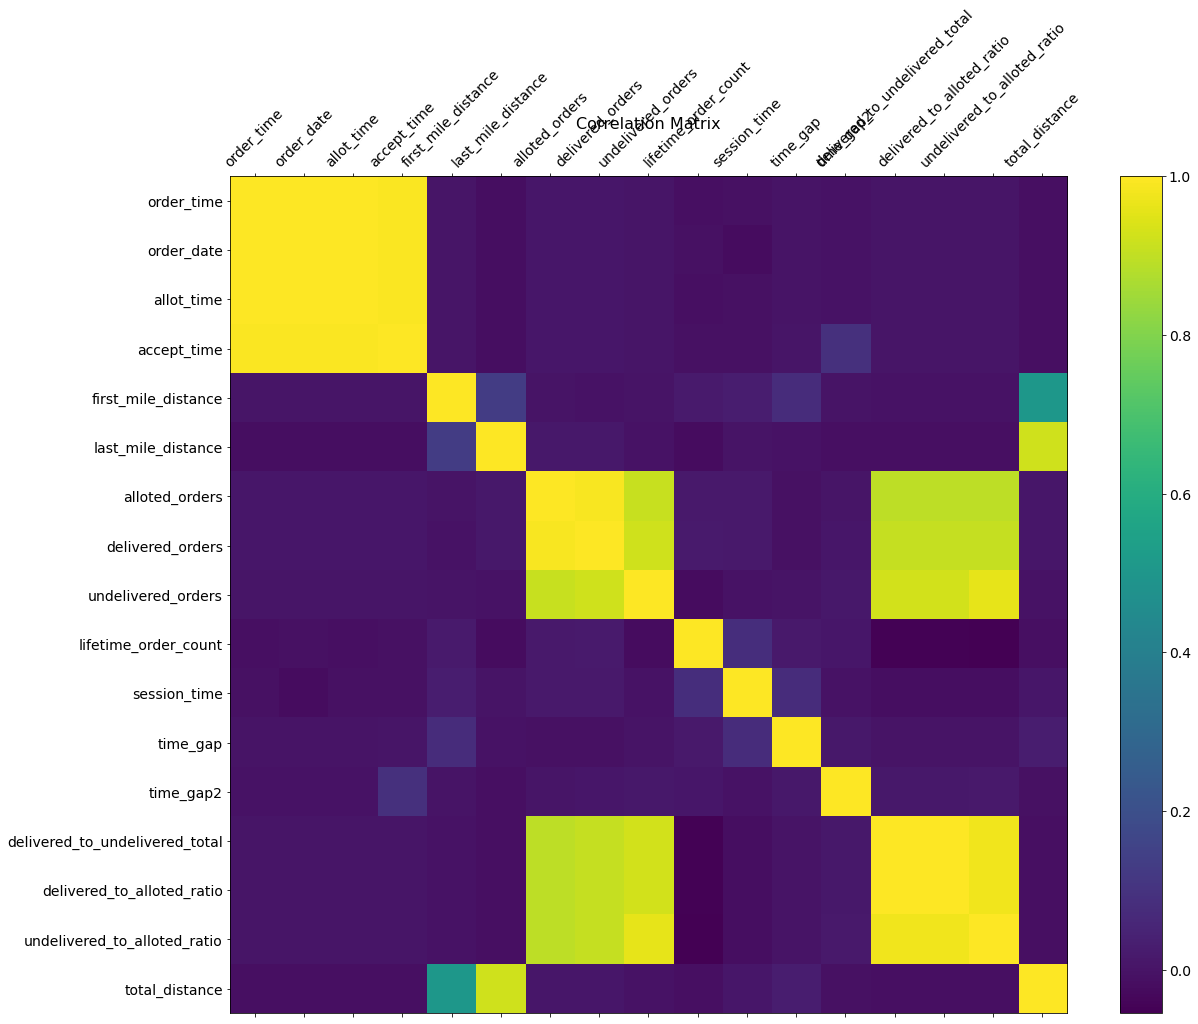

In [7]:
import matplotlib.pyplot as plt

f = plt.figure(figsize=(19, 15))
plt.matshow(X.corr(), fignum=f.number)
plt.xticks(range(X.select_dtypes(['number']).shape[1]), X.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(X.select_dtypes(['number']).shape[1]), X.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

In [8]:
X.shape

(450000, 17)

###Train-Test Split

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.9, test_size=0.1)
X_train.head()

,order_time,order_date,allot_time,accept_time,first_mile_distance,last_mile_distance,alloted_orders,delivered_orders,undelivered_orders,lifetime_order_count,session_time,time_gap,time_gap2,delivered_to_undelivered_total,delivered_to_alloted_ratio,undelivered_to_alloted_ratio,total_distance
17634,0.043030,0.000000,0.042878,0.042910,0.045915,0.186970,0.049470,0.049911,0.000000,0.005908,0.025443,0.000062,0.969794,1.000000,1.000000,0.000000,0.133488
80295,0.195247,0.181818,0.194637,0.194745,0.061015,0.195002,0.219081,0.221034,0.000000,0.150054,0.089494,0.000031,0.972339,1.000000,1.000000,0.000000,0.151269
154155,0.319025,0.272727,0.318042,0.318059,0.019239,0.199465,0.031802,0.032086,0.000000,0.002429,0.352626,0.000031,0.969251,1.000000,1.000000,0.000000,0.115127
345698,0.757574,0.727273,0.755287,0.755313,0.000216,0.190094,0.192580,0.192513,0.111111,0.007746,0.122585,0.000433,0.969556,0.989091,0.989091,0.010909,0.093093
262875,0.580067,0.545455,0.578338,0.578871,0.018368,0.136546,0.263251,0.263815,0.111111,0.011060,0.262747,0.001175,0.986424,0.992000,0.992000,0.008000,0.083559


In [10]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(405000, 17)
(405000,)
(45000, 17)
(45000,)


#Test Data

###Preprocessing Test Data

In [11]:
df_test = pd.read_csv('/content/drive/My Drive/Cascade_Cup/test.csv')

In [12]:
IDs = df_test['order_id']

In [13]:
def preprocessing_data_test(df):
  date_time_cols = ['order_time', 'order_date', 'allot_time', 'accept_time']
  diff_from = pd.to_datetime('2021-01-26 00:00:00')
  for i in date_time_cols:
    df[i] = pd.to_datetime(df[i]);
    df[i] = (df[i] - diff_from).dt.total_seconds()

  # df['reassignment_method'] = df['reassignment_method'].map({'auto':1, 'manual':2})
  # df['reassignment_reason'] = df['reassignment_reason'].map({'Reassignment Request from SE portal.' : 1,
  #      'Auto Reassignment basis Inaction. coreengine.tasks.repush_order_to_aa_bucket' : 2,
  #      'Reassign' : 3})
  df = df.drop(['rider_id', 'order_id', 'reassignment_method', 'reassignment_reason', 'reassigned_order'], axis = 1)
  df = df.fillna(0)
  df['time_gap'] = df['allot_time'] - df['order_time']
  df['time_gap2'] = df['accept_time'] - df['allot_time']
  df['delivered_to_undelivered_total'] = df['delivered_orders'] / (df['undelivered_orders'] + df['delivered_orders'])
  df['delivered_to_alloted_ratio'] = df['delivered_orders'] / df['alloted_orders']
  df['undelivered_to_alloted_ratio'] = df['undelivered_orders'] / df['alloted_orders']
  df['total_distance'] = df['first_mile_distance'] + df['last_mile_distance']
  df[df.columns] = scaler.fit_transform(df[df.columns])
  df = df.fillna(2)
  X = df

  return X

In [14]:
test_X = preprocessing_data_test(df_test)
test_X.head()

,order_time,order_date,allot_time,accept_time,first_mile_distance,last_mile_distance,alloted_orders,delivered_orders,undelivered_orders,lifetime_order_count,session_time,time_gap,time_gap2,delivered_to_undelivered_total,delivered_to_alloted_ratio,undelivered_to_alloted_ratio,total_distance
0,0.000000,0.0,0.000074,0.768615,0.030325,0.219536,0.387097,0.388788,0.1,0.024517,0.225891,0.002047,0.999262,0.994444,0.995370,0.005556,0.100332
1,0.000007,0.0,0.000000,0.768585,0.037866,0.282398,0.093190,0.094033,0.0,0.002462,0.208293,0.000082,0.999249,1.000000,1.000000,0.000000,0.128105
2,0.000010,0.0,0.000158,0.768677,0.025387,0.047872,0.517921,0.522604,0.0,0.072664,0.199438,0.003848,0.999304,1.000000,1.000000,0.000000,0.038376
3,0.000017,0.0,0.000010,0.768598,0.034812,0.125242,0.224014,0.220615,0.3,0.033477,0.241204,0.000082,0.999260,0.971200,0.976000,0.028800,0.072686
4,0.000037,0.0,0.000054,0.768637,0.015131,0.045455,0.630824,0.632911,0.2,0.239063,0.204189,0.000655,0.999289,0.993182,0.994318,0.006818,0.028468


In [15]:
test_X.shape

(144844, 17)

#Confusion Matix func

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support
def represent_best(X_train, Y_train, X_test, Y_test, clf, train_score, auc_train_score, test_score, auc_test_score):
  print("Train Data: \n\n")
  print("Accuracy:", train_score, "\n")
  print("AUC_ROC Score:", auc_train_score, "\n")
  print("Confusion Matrix Train\n")
  cm1 = confusion_matrix(Y_train, clf.predict(X_train) , labels=clf.classes_)
  disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1,
                           display_labels=clf.classes_)
  disp1.plot()
  plt.show()

  print("Test Data: \n\n")
  print("Accuracy:", test_score, "\n")
  print("AUC_ROC Score:", auc_test_score, "\n")
  print("Confusion Matrix Train")
  cm2  = confusion_matrix(Y_test, clf.predict(X_test), labels=clf.classes_)
  disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2,
                           display_labels=clf.classes_)
  disp2.plot()
  plt.show()

In [17]:
def get_confusion_matrix(pred_train, Y_train, pred_test, Y_test, clf):
  print("Train Data:\n")
  cm1 = confusion_matrix(Y_train, pred_train , labels=clf.classes_)
  disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1,
                           display_labels=clf.classes_)
  disp1.plot()
  plt.show()

  print("Test Data:\n")
  cm2  = confusion_matrix(Y_test, pred_test, labels=clf.classes_)
  disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2,
                           display_labels=clf.classes_)
  disp2.plot()
  plt.show()

#Prediction func

In [18]:
def prediction(clf, test_X):
  predictions = clf.predict(test_X)
  pred = {'order_id': IDs, 'cancelled' : predictions}
  submission = pd.DataFrame(data = pred)

  return submission

#Logistic Regression
Score(kaggle): (0.64 - 0.65)

####Model

In [19]:
from sklearn.linear_model import LogisticRegression
def Logistic_reg(X_train, Y_train, X_test, Y_test, tol_val, C_val, max_iter_val):
  clf = LogisticRegression(penalty='l2', class_weight='balanced', tol=tol_val, C=C_val, random_state=0, max_iter = max_iter_val).fit(X_train, Y_train)
  train_score = clf.score(X_train, Y_train)
  test_score = clf.score(X_test, Y_test)
  auc_score1 = roc_auc_score(Y_train, clf.predict(X_train))
  auc_score2 = roc_auc_score(Y_test, clf.predict(X_test))

  return clf, train_score, test_score, auc_score1, auc_score2

####Hyperparameter Tuning

In [20]:
max_iter = [1e+4]
tol = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
C = [1, 1e+1, 1e+2, 1e+3, 1e+4, 1e+5, 1e+6]
values = []
count = 1
for k in max_iter:
  for i in tol:
    for j in C:
      print(count,' ')
      count = count + 1
      clf, train_score, test_score, auc_train_score, auc_test_score = Logistic_reg(X_train, Y_train, X_test, Y_test, i, j, k)
      values.append([k, i, j, train_score, test_score, auc_train_score, auc_test_score])

1  
2  
3  
4  
5  
6  
7  
8  
9  
10  
11  
12  
13  
14  
15  
16  
17  
18  
19  
20  
21  
22  
23  
24  
25  
26  
27  
28  
29  
30  
31  
32  
33  
34  
35  
36  
37  
38  
39  
40  
41  
42  
43  
44  
45  
46  
47  
48  
49  


In [21]:
values_tables = pd.DataFrame(values, columns = ['max_iter', 'tol','C','train_score', 'test_score', 'auc_train_score', 'auc_test_score'])
values_tables.head()

,max_iter,tol,C,train_score,test_score,auc_train_score,auc_test_score
0,10000.0,0.000001,1.0,0.831077,0.832578,0.679691,0.672020
1,10000.0,0.000001,10.0,0.830800,0.832644,0.680077,0.671111
2,10000.0,0.000001,100.0,0.831037,0.832778,0.680302,0.671178
3,10000.0,0.000001,1000.0,0.830943,0.832733,0.680255,0.671156
4,10000.0,0.000001,10000.0,0.830896,0.832622,0.680126,0.671099


Accuracy Vs AUR_ROC

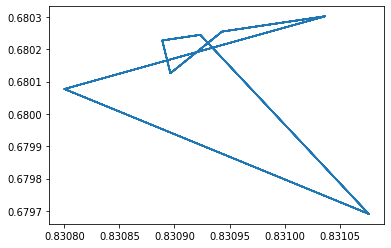

In [22]:
plt.plot(values_tables['train_score'], values_tables['auc_train_score'])

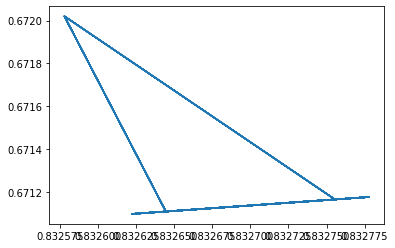

In [23]:
plt.plot(values_tables['test_score'], values_tables['auc_test_score'])

In [24]:
print("Test Accuracy:", values_tables['test_score'].max(), "\n", "AUC_ROC Test Score:", values_tables['auc_test_score'].max(), "\n", "Train Accuracy:", values_tables['train_score'].max(),"\n", "AUC_ROC Train Score:", values_tables['auc_train_score'].max())

Test Accuracy: 0.8327777777777777 
 AUC_ROC Test Score: 0.6720198697093002 
 Train Accuracy: 0.8310765432098766 
 AUC_ROC Train Score: 0.6803023233029885


In [25]:
print('test_accuracy_idx:', values_tables['test_score'].idxmax(), '\nauc_test_score_idx:', values_tables['auc_test_score'].idxmax(), '\ntrain_accuracy_idx:', values_tables['train_score'].idxmax(), '\naur_train_accuracy_idx:', values_tables['auc_train_score'].idxmax())

test_accuracy_idx: 2 
auc_test_score_idx: 0 
train_accuracy_idx: 0 
aur_train_accuracy_idx: 2


Getting Hyperparameters with best scores

In [26]:
for i in [0, 2]:
  print(values_tables[i:(i+1)])

   max_iter       tol    C  ...  test_score  auc_train_score  auc_test_score
0   10000.0  0.000001  1.0  ...    0.832578         0.679691         0.67202

[1 rows x 7 columns]
   max_iter       tol      C  ...  test_score  auc_train_score  auc_test_score
2   10000.0  0.000001  100.0  ...    0.832778         0.680302        0.671178

[1 rows x 7 columns]


Final Model

In [28]:
clf_logistic, train_score_logistic, test_score_logistic, auc_train_score_logistic, auc_test_score_logistic = Logistic_reg(X, Y, X_test, Y_test, 0.000001, 1.0 ,1e+7)
print("Train Accuracy:", train_score_logistic, "\n", "AUR_ROC Score Train:", auc_train_score_logistic, "\n", "Test Accuracy:", test_score_logistic, "\n", "AUC_ROC Score Test:", auc_test_score_logistic, "\n")

Train Accuracy: 0.8325333333333333 
 AUR_ROC Score Train: 0.6795809999515028 
 Test Accuracy: 0.8344888888888888 
 AUC_ROC Score Test: 0.6729866832716709 



Confusion Matix

Train Data: 


Accuracy: 0.8325333333333333 

AUC_ROC Score: 0.6795809999515028 

Confusion Matrix Train



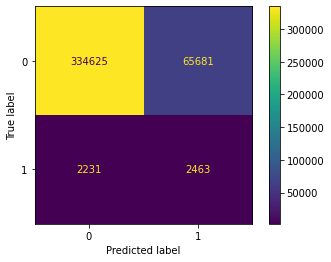

Test Data: 


Accuracy: 0.8344888888888888 

AUC_ROC Score: 0.6729866832716709 

Confusion Matrix Train


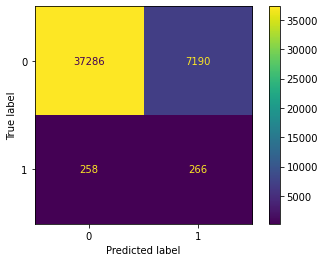

In [29]:
represent_best(X_train, Y_train, X_test, Y_test, clf_logistic, train_score_logistic, auc_train_score_logistic, test_score_logistic, auc_test_score_logistic)

In [30]:
test_X.shape

(144844, 17)

Prediction

In [31]:
result_logistic = prediction(clf_logistic, test_X)
result_logistic.to_csv('result_logistic.csv', index = False)

#Random Forest
Score(kaggle): (0.64 - 0.67)

####Model

In [32]:
from sklearn.ensemble import RandomForestClassifier
def random_forest(X_train, Y_train, X_test, Y_test, no_of_trees_val, max_depth_val):
      clf = RandomForestClassifier(n_estimators = no_of_trees_val, max_depth = max_depth_val,
                                   random_state=0,class_weight= "balanced").fit(X_train, Y_train)
      train_score = clf.score(X_train, Y_train)
      test_score = clf.score(X_test, Y_test)
      auc_score1 = roc_auc_score(Y_train, clf.predict(X_train))
      auc_score2 = roc_auc_score(Y_test, clf.predict(X_test))

      return clf, train_score, test_score, auc_score1, auc_score2

In [33]:
no_of_trees = [1, 2, 5, 10, 15, 20, 50, 100]
max_depth = [1, 2, 5, 1e+1, 50, 100]
val_random_forest = []
count = 1
for i in no_of_trees:
  for j in max_depth:
      print(count,' ')
      count = count + 1
      clf, train_score, test_score, auc_train_score, auc_test_score = random_forest(X_train, Y_train, X_test, Y_test, i, j)
      val_random_forest.append([i, j, train_score, auc_train_score, test_score, auc_test_score])

1  
2  
3  
4  
5  
6  
7  
8  
9  
10  
11  
12  
13  
14  
15  
16  
17  
18  
19  
20  
21  
22  
23  
24  
25  
26  
27  
28  
29  
30  
31  
32  
33  
34  
35  
36  
37  
38  
39  
40  
41  
42  
43  
44  
45  
46  
47  
48  


In [34]:
table_random_forest = pd.DataFrame(val_random_forest, columns = ['no_of_trees','max_depth','train_score', 'auc_train_score', 'test_score','auc_test_score'])
table_random_forest.head()

,no_of_trees,max_depth,train_score,auc_train_score,test_score,auc_test_score
0,1,1.0,0.952099,0.564163,0.951511,0.561512
1,1,2.0,0.947914,0.587942,0.947489,0.586823
2,1,5.0,0.858370,0.641600,0.859733,0.635781
3,1,10.0,0.858477,0.678708,0.858356,0.657715
4,1,50.0,0.992477,0.832184,0.980044,0.544829


In [35]:
table_random_forest.shape[0]

48

####Accuracy Vs AUR_ROC

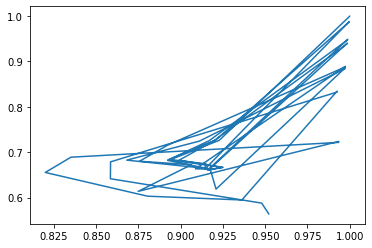

In [36]:
plt.plot(table_random_forest['train_score'], table_random_forest['auc_train_score'])

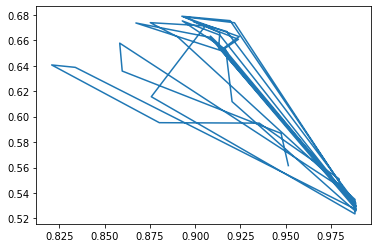

In [37]:
plt.plot(table_random_forest['test_score'], table_random_forest['auc_test_score'])

####Getting Hyperparameters with best scores

In [38]:
print('test_accuracy:', table_random_forest['test_score'].max(),'\nauc_test_score:',table_random_forest['auc_test_score'].max(), '\ntrain_accuracy:', table_random_forest['train_score'].max(),'\nauc_train_score:', table_random_forest['auc_train_score'].max())

test_accuracy: 0.9889111111111111 
auc_test_score: 0.6788443754552589 
train_accuracy: 0.9999802469135802 
auc_train_score: 0.9991478483170004


In [39]:
print('test_score_idx:',table_random_forest['test_score'].idxmax(),'\nauc_test_score_idx:',table_random_forest['auc_test_score'].idxmax(),'\ntrain_score_idx:', table_random_forest['train_score'].idxmax(),'\nauc_train_score_idx:', table_random_forest['auc_train_score'].idxmax())

test_score_idx: 41 
auc_test_score_idx: 38 
train_score_idx: 47 
auc_train_score_idx: 47


In [40]:
for i in [41, 38, 47]:
  print(table_random_forest[i:(i+1)])
  print(table_random_forest[i:(i+1)].max_depth)

    no_of_trees  max_depth  ...  test_score  auc_test_score
41           50      100.0  ...    0.988911        0.529513

[1 rows x 6 columns]
41    100.0
Name: max_depth, dtype: float64
    no_of_trees  max_depth  ...  test_score  auc_test_score
38           50        5.0  ...    0.892667        0.678844

[1 rows x 6 columns]
38    5.0
Name: max_depth, dtype: float64
    no_of_trees  max_depth  ...  test_score  auc_test_score
47          100      100.0  ...    0.988844         0.52665

[1 rows x 6 columns]
47    100.0
Name: max_depth, dtype: float64


####Final Model

In [41]:
clf_random_forest, train_score_random_forest, test_score_random_forest, auc_train_score_random_forest, auc_test_score_random_forest = random_forest(X, Y, X_test, Y_test, 50, 5)
print('train_accuracy:', train_score_random_forest, '\ntest_accuracy:', test_score_random_forest,'\nauc_train_score:', auc_train_score_random_forest,'\nauc_test_score:', auc_test_score_random_forest)

train_accuracy: 0.89954 
test_accuracy: 0.8993777777777778 
auc_train_score: 0.6839316021945878 
auc_test_score: 0.681296508486608


####Confusion Matix

Train Data: 


Accuracy: 0.89954 

AUC_ROC Score: 0.6839316021945878 

Confusion Matrix Train



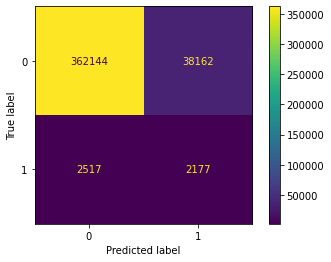

Test Data: 


Accuracy: 0.8993777777777778 

AUC_ROC Score: 0.681296508486608 

Confusion Matrix Train


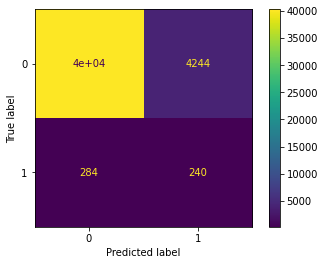

In [42]:
represent_best(X_train, Y_train, X_test, Y_test, clf_random_forest, train_score_random_forest, auc_train_score_random_forest, test_score_random_forest, auc_test_score_random_forest)

####Prediction

In [43]:
result_random_forest = prediction(clf_random_forest, test_X)
result_random_forest.to_csv('result_random_forest.csv', index = False)

#Gradient-Boosted Tree
Score(kaggle): Around 0.5

Model

In [44]:
from sklearn.ensemble import GradientBoostingClassifier
def gradient_boost(X_train, Y_train, X_test, Y_test, alpha, tol_value):
  clf = GradientBoostingClassifier(learning_rate=alpha, random_state=0,
                             tol=tol_value).fit(X_train, Y_train)
                            
  train_score = clf.score(X_train, Y_train)
  test_score = clf.score(X_test, Y_test)
  auc_score1 = roc_auc_score(Y_train, clf.predict(X_train))
  auc_score2 = roc_auc_score(Y_test, clf.predict(X_test))

  return clf, train_score, test_score, auc_score1, auc_score2

Hyperparameter Tuning

In [45]:
alpha = [1e-4, 1e-3, 1e-2, 1e-1, 1]
tol = [1e-4, 1e-3, 1e-2, 1e-1, 1]
val_gradient = []
count = 1
for i in tol:
  for j in alpha:
    print(count, ' ')
    count = count + 1
    clf, train_score, test_score,  auc_train_score, auc_test_score = gradient_boost(X_train, Y_train, X_test, Y_test, j, i)
    print( train_score, auc_train_score,  test_score,  auc_test_score)
    val_gradient.append([i, j, train_score, auc_train_score,  test_score,  auc_test_score])

1  
0.9884098765432099 0.5 0.9883555555555555 0.5
2  
0.9884098765432099 0.5 0.9883555555555555 0.5
3  
0.9887975308641975 0.5167234767788667 0.9887111111111111 0.5152671755725191
4  
0.9893530864197531 0.5499539954618995 0.9890666666666666 0.5427927850615376
5  
0.9888765432098765 0.5203426233426529 0.9887555555555556 0.517175572519084
6  
0.9884098765432099 0.5 0.9883555555555555 0.5
7  
0.9884098765432099 0.5 0.9883555555555555 0.5
8  
0.9887975308641975 0.5167234767788667 0.9887111111111111 0.5152671755725191
9  
0.9893530864197531 0.5499539954618995 0.9890666666666666 0.5427927850615376
10  
0.9888765432098765 0.5203426233426529 0.9887555555555556 0.517175572519084
11  
0.9884098765432099 0.5 0.9883555555555555 0.5
12  
0.9884098765432099 0.5 0.9883555555555555 0.5
13  
0.9887975308641975 0.5167234767788667 0.9887111111111111 0.5152671755725191
14  
0.9893530864197531 0.5499539954618995 0.9890666666666666 0.5427927850615376
15  
0.9888765432098765 0.5203426233426529 0.988755555555

In [46]:
val_gradient_table = pd.DataFrame(val_gradient, columns = ['tol','alpha','train_score', 'auc_train_score',  'test_score',  'auc_test_score'])
val_gradient_table.head()

,tol,alpha,train_score,auc_train_score,test_score,auc_test_score
0,0.0001,0.0001,0.988410,0.500000,0.988356,0.500000
1,0.0001,0.0010,0.988410,0.500000,0.988356,0.500000
2,0.0001,0.0100,0.988798,0.516723,0.988711,0.515267
3,0.0001,0.1000,0.989353,0.549954,0.989067,0.542793
4,0.0001,1.0000,0.988877,0.520343,0.988756,0.517176


Accuracy Vs AUR_ROC

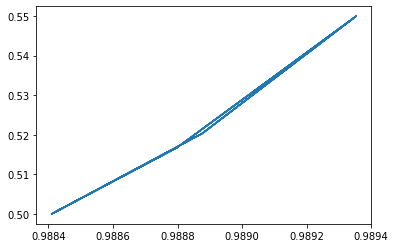

In [47]:
plt.plot(val_gradient_table['train_score'], val_gradient_table['auc_train_score'])

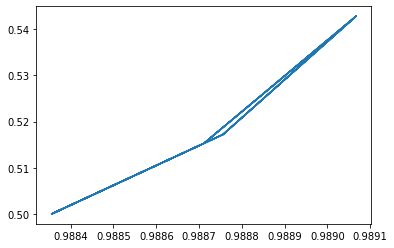

In [48]:
plt.plot(val_gradient_table['test_score'], val_gradient_table['auc_test_score'])

Getting Hyperparameters with best scores

In [49]:
print(val_gradient_table['test_score'].max(),val_gradient_table['auc_test_score'].max(), val_gradient_table['train_score'].max(), val_gradient_table['auc_train_score'].max())

0.9890666666666666 0.5427927850615376 0.9893530864197531 0.5499539954618995


In [50]:
print(val_gradient_table['test_score'].idxmax(),val_gradient_table['auc_test_score'].idxmax(), val_gradient_table['train_score'].idxmax(), val_gradient_table['auc_train_score'].idxmax())

3 3 3 3


In [51]:
print(val_gradient_table[3:4])

      tol  alpha  train_score  auc_train_score  test_score  auc_test_score
3  0.0001    0.1     0.989353         0.549954    0.989067        0.542793


Final Model

In [52]:
clf_grd_boost, train_score_grd_boost, test_score_grd_boost, auc_train_score_grd_boost, auc_test_score_grd_boost = gradient_boost(X_train, Y_train, X_test, Y_test,0.1,0.0001)
print(train_score_grd_boost, test_score_grd_boost, auc_train_score_grd_boost, auc_test_score_grd_boost)

0.9893530864197531 0.9890666666666666 0.5499539954618995 0.5427927850615376


Confusion Matix

Train Data: 


Accuracy: 0.9893530864197531 

AUC_ROC Score: 0.5499539954618995 

Confusion Matrix Train



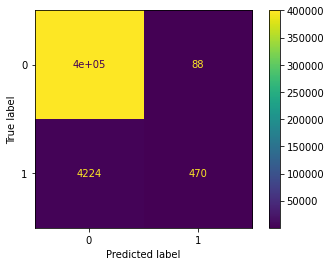

Test Data: 


Accuracy: 0.9890666666666666 

AUC_ROC Score: 0.5427927850615376 

Confusion Matrix Train


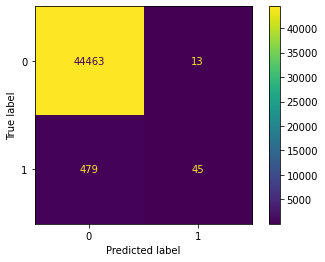

In [55]:
represent_best(X_train, Y_train, X_test, Y_test, clf_grd_boost, train_score_grd_boost, auc_train_score_grd_boost, test_score_grd_boost, auc_test_score_grd_boost)

Prediction

In [56]:
result_grd_boost = prediction(clf_grd_boost, test_X)
result_grd_boost.to_csv('result_grd_boost.csv', index = False)